# Getting Started


In this file we will visit the basic functionalities provided by Dionysos for the optimal control of complex systems. In summary, the topics covered are
- Grids and discretizations
- Dynamical system declaration
- Continuous and discrete state image mapping
- Plotting

First, let us import a few packages that are necessary to run this example.

In [1]:
using Dionysos
using StaticArrays
using LinearAlgebra
using PyPlot

The main package [Dionysos](https://github.com/dionysos-dev/Dionysos.jl) provides most important data structures that we will need.
Additionally  [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) provides faster implementation of Arrays (which have static memory allocation),
[LinearAlgebra](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) allows us to perform some additional operations and [PyPlot](https://github.com/JuliaPy/PyPlot.jl) is
important for data visualization.

In [2]:
include("../../../src/plotting.jl")

Main.##260.Plot

The submodule [plotting.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/src/plotting.jl) has functions that will be useful for 2D-visualization of the functions that we are implementing.

In [3]:
const AB = Dionysos.Abstraction;

Additionally, we will short the [Abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/src/Abstraction/abstraction.jl) submodule as `AB`

We use `HyperRectangle` to represent the boundary of the state space `rectX` and the input space `rectU`.

In [4]:
rectX = AB.HyperRectangle(SVector(-2, -2), SVector(2, 2));
rectU = AB.HyperRectangle(SVector(-5), SVector(5));

A discretization of the state space is declared using the `GridFree` structure, which requires the definition of a center `x0` and
a vector `h` of discretization steps in each direction.

In [5]:
x0 = SVector(0.0, 0.0);
h = SVector(1.0/5, 1.0/5);
Xgrid = AB.GridFree(x0, h);

`Xgrid` represents the state space grid and holds information of `x0` and `h`, but is not a collection of cells. Indeed, a cell can be efficiently represented by a tuple of `Int`, for instance 'pos', with which the corresponding cartesian position can be computed by `x0 + h .* pos` or using functions to be shown. In Dionysos, a set of cells is called a `Domain`
and the `DomainList` structure is used to represent this set. In the following, `domainX` is defined as an empty `DomainList` over the grid `Xgrid` and the `add_set!`
method is responsible for adding a set of cells to the `DomainList`

In [6]:
domainX = AB.DomainList(Xgrid);
AB.add_set!(domainX, rectX, AB.INNER)

In this last line of code, `add_set!` add all the cells of the grid `Xgrid` to the DomainList `domainX` that are contained in the HyperRectangle `rectX`
Construction of the struct `DomainList` containing the feasible cells of the state-space.
Note, we used `AB.INNER` to make sure to add cells entirely contained in the domain. If we would like to add also cells partially covered by a given
HyperRectangle, `AB.OUTER` should be used instead.

Similarly, we define a discretization of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [7]:
u0 = SVector(0.0);
h = SVector(1.0/5);
Ugrid = AB.GridFree(u0, h);
domainU = AB.DomainList(Ugrid);
AB.add_set!(domainU, rectU, AB.INNER);

Now we have to define our dynamical system. For the sake of simplicity, note that we consider a linear time-invariant dynamical system but the functions
defining it allow the definition of a generic nonlinear and time-dependent system. We also define a step time `tstep` for discretizing the continuous-time dynamic.
The parameters

In [8]:
tstep = 0.1;
nsys=10; # Runge-Kutta pre-scaling


A = SMatrix{2,2}(0.0, 1.0,
                -3.0, 1.0);
B = SMatrix{2,1}(0.0, 1.0);

F_sys = let A = A
    (x,u) -> A*x + B*u
end;

We also need to define a growth-bound function, which allows for the state-space discretization errors. For more details on growth bounds, please refer to [(Reissig, Weber, and Rungger, 2016)](https://arxiv.org/pdf/1503.03715v1.pdf).

In [9]:
ngrowthbound=10; # Runge-Kutta pre-scaling
A_diag = diagm(diag(A));
A_abs = abs.(A) - abs.(A_diag) + A_diag
L_growthbound = x -> abs.(A)

#3 (generic function with 1 method)

Finally we define the bounds on the input noise `sysnoise` and for the measurement noise `measnoise` of the system

In [10]:
measnoise = SVector(0.0, 0.0);
sysnoise = SVector(0.0, 0.0);

And now the instantiation of the ControlSystem

In [11]:
contsys = AB.NewControlSystemGrowthRK4(tstep, F_sys, L_growthbound, sysnoise,
                                       measnoise, nsys, ngrowthbound);

With that in hand, we can now proceed to the construction of a symbolic model of our system

In [12]:
symmodel = AB.NewSymbolicModelListList(domainX, domainU);

The method `compute_symmodel_from_controlsystem!` builds the transitions of the symbolic control system based on the provided domains and the dynamics
defined in `contsys`

In [13]:
AB.compute_symmodel_from_controlsystem!(symmodel, contsys)

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 68817 transitions created


Let us now explore what transitions have been created considering, for instance, the state `x`=[1.1  1.3] and the input `u`=-1. First, let us pin point the cell in the grid
associated with this state and this input. The method `get_pos_by_coord` returns a tuple of integers defining the indices of a cell coontaining a given coordinate.

In [14]:
xpos = AB.get_pos_by_coord(Xgrid, SVector(1.1, 1.3))
upos = AB.get_pos_by_coord(Ugrid, SVector(-1))

(-5,)

On the other hand, `get_coord_by_pos` returns the coordinates of the center of a cell defined by its indices.

In [15]:
x = AB.get_coord_by_pos(Xgrid, xpos)
u = AB.get_coord_by_pos(Ugrid, upos)

1-element StaticArrays.SVector{1, Float64} with indices SOneTo(1):
 -1.0

Now we create the vector `post` to receive the number of all the cells that are in the Post of `x` under `u`.

In [16]:
post = Int[]
AB.compute_post!(post, symmodel.autom, symmodel.xpos2int[xpos], symmodel.upos2int[upos])

It is important to highlight the differences between `xpos` and the elements of `post`. The Tuple `xpos`
contains information about a cell with respect to the grid `Xgrid` whereas the elements of `post` are Int's
containing an internal code of each cell added to the Symbolic Model `symmodel`. To alterante between the
two different representations we use the dictionaries `xint2pos` and `xpos2int`. Similarly, the same can be said
about `upos`. That said, we can build a domain of Post of `xpos` under `upos` as following:

In [17]:
domainPostx = AB.DomainList(Xgrid);
for pos in symmodel.xint2pos[post]
    AB.add_pos!(domainPostx,pos)
end

Let us visualize this

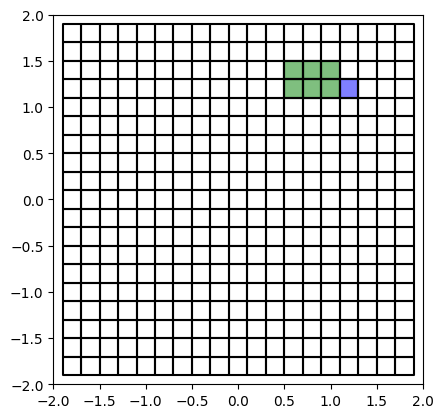

In [18]:
fig = PyPlot.figure()

ax = PyPlot.axes(aspect = "equal")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

vars = [1, 2];
Plot.domain!(ax, vars, domainX, fc = "white")
Plot.cell!(ax, vars, Xgrid, xpos, fc = "blue")
Plot.domain!(ax, vars, domainPostx, fc = "green")
gcf()

In the previous picture, we have the state space lattice in white, the chosen cell `xpos` in blue and
the corresponding Post domain in green. The argument `vars` given to the Plot functions refer to the projection
of the state space onto the subspace of variables 1 and 2. In this case this is an identity mapping but for
higher-order systems, this projection is useful to visualize the behavior of the system on a 2-dimensional space.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*